# Black-Scholes Autodifferentiation Example
In this example we are calculating $\theta$ values using the Black-Scholes model.

In [19]:
# Imports & Constants
import tributary.streaming as ts
import math
import matplotlib.pyplot as plt
import asyncio
TRADING_DAYS = 252

## We can use the tributary $\textit{Erf}$ operator to define a Standard Normal CDF
The CDF is defined using $\Phi(x, \mu, \sigma) = \frac{1}{2}\left(1 + Erf\left(\frac{x-\mu}{\sigma\sqrt{2}}\right)\right)$ for $\mu = 0, \sigma = 1$

In [20]:
def normal_cdf(x):
    return ((ts.Erf(x / ts.Const((math.sqrt(2),0), use_dual=True)) + ts.Const((1,0), use_dual=True))
            / ts.Const((2,0), use_dual=True))

## Now we can define our streams
For this example we are going use a Call Option.
We define the model as follows:

$C_p = S\Phi(d_1) - Xe^{-rt}\Phi(d_2)$

$d_1 = \frac{ln\left(\frac{S}{X}\right) + \left(r + \frac{\sigma^2}{2}\right)t}{\sigma\sqrt{t}}$

$d_2 = d_1 - \sigma\sqrt{t}$

Where

$C_p$ - Price of Call Option

$S$ - Stock Price

$X$ - Strike Price

$r$ - Risk Free Interest Rate

$\sigma$ - Stock Price Volatility

$t$ - Time to Maturity

$\Phi$ - Standard Normal CDF (defined above)

### Streaming Graph

In [22]:
def _time():
    for _ in [1, 2, 3, 4, 5, 6, 7]:
        yield (_, 1)

strike_price = ts.Const((203,0), use_dual=True)
stock_price = ts.Const((210,0), use_dual=True)
r = ts.Const((0.2175, 0), use_dual=True)
time = ts.Div(
              ts.Node(func=_time, name='Time', use_dual=True), 
              ts.Const((TRADING_DAYS,0), use_dual=True)
        )
vol = ts.Const((14.04, 0), use_dual=True)
   

d1 = (((ts.Log(stock_price / strike_price) + time * (r + vol**2 / ts.Const((2,0), use_dual=True)))
       / vol*ts.Sqrt(time)))

d2 = d1 - vol*ts.Sqrt(time)

opt_price_streaming = stock_price * normal_cdf(d1) - strike_price * ts.Exp(ts.Negate(r * time)) * normal_cdf(d2)

In [23]:
# Run It
out_streaming = ts.run(opt_price_streaming)
while not out_streaming.done():
    await asyncio.sleep(1)

## Let's do some plots

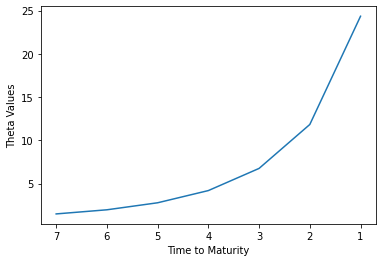

In [24]:
thetas = [x[1] for x in out_streaming.result()]
plt.plot([x[0] for x in _time()], thetas)
plt.xlabel('Time to Maturity')
plt.ylabel('Theta Values')
plt.gca().invert_xaxis()

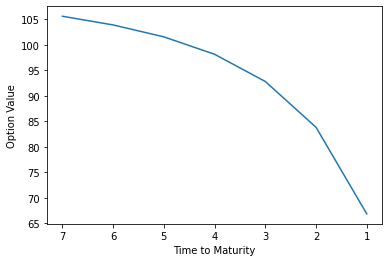

In [25]:
option_value = [x[0] for x in out_streaming.result()]
plt.plot([x[0] for x in _time()], option_value)
plt.xlabel('Time to Maturity')
plt.ylabel('Option Value')
plt.gca().invert_xaxis()